# 📊 Data Processing

In [2]:
# Use the same kernal with Step 0
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

## Raw data processing

In [3]:
# Select the Date and Target columns from the dataset
df = pd.read_csv(file)
# df = pd.read_excel(file)
df = df[["date", target]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        144 non-null    object
 1   passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
# Convert to datetime 
df["date"] = pd.to_datetime(df["date"])

# Handling missing values
df[target] = df[target].interpolate()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        144 non-null    datetime64[ns]
 1   passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [5]:
df.head(10)

,date,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
5,1949-06-01,135
6,1949-07-01,148
7,1949-08-01,148
8,1949-09-01,136
9,1949-10-01,119


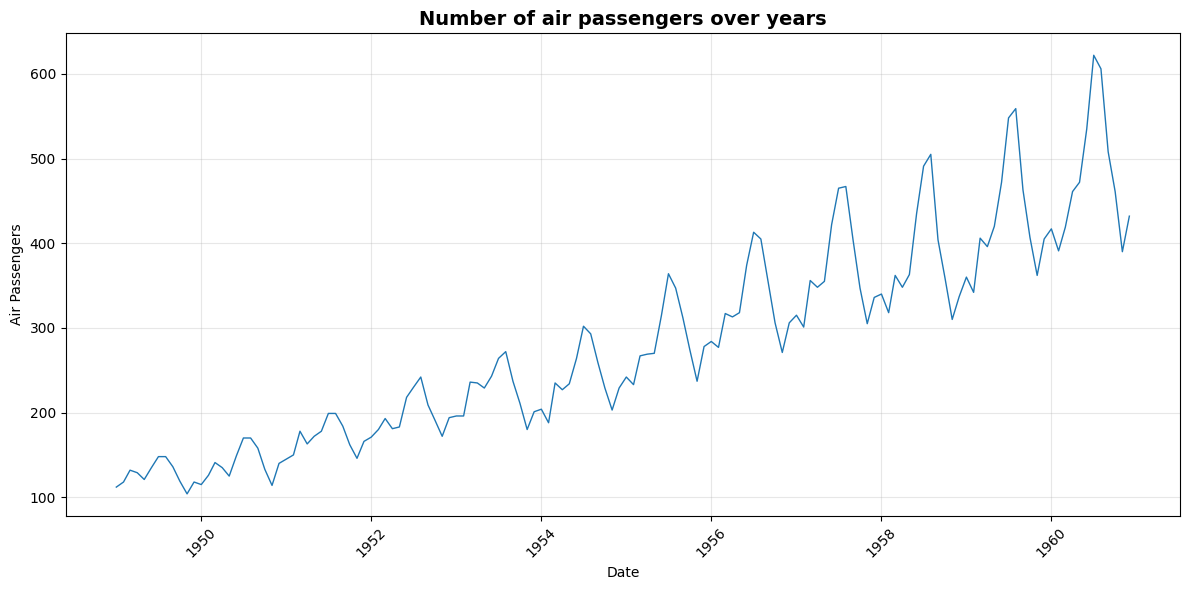

In [6]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df[target], linewidth=1)
ax.set_xlabel("Date")
ax.set_ylabel(target_name_for_plot)
ax.set_title(name_of_plot, fontsize=14, fontweight="bold")

# Formatting
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Note: This time series is non-stationary, which means its statistical properties (such as mean and variance) change over time. Therefore, it must be transformed into a stationary series before building forecasting models.

## Train-Test Split

In [7]:
# Set the ratio for training set
train_ratio = 0.8 # train_ratio for training, validation and (100 - train_ratio) for testing

# Get the total number of samples
num_samples = len(df)

# Split the series into training and testing sets
data_train = df[:int(num_samples * train_ratio)] # include "date" and target column
y_train = data_train[[target]]
y_test = df[target][int(num_samples * train_ratio):]

In [8]:
print(len(df))
print(len(y_train))
print(len(y_test))

144
115
29


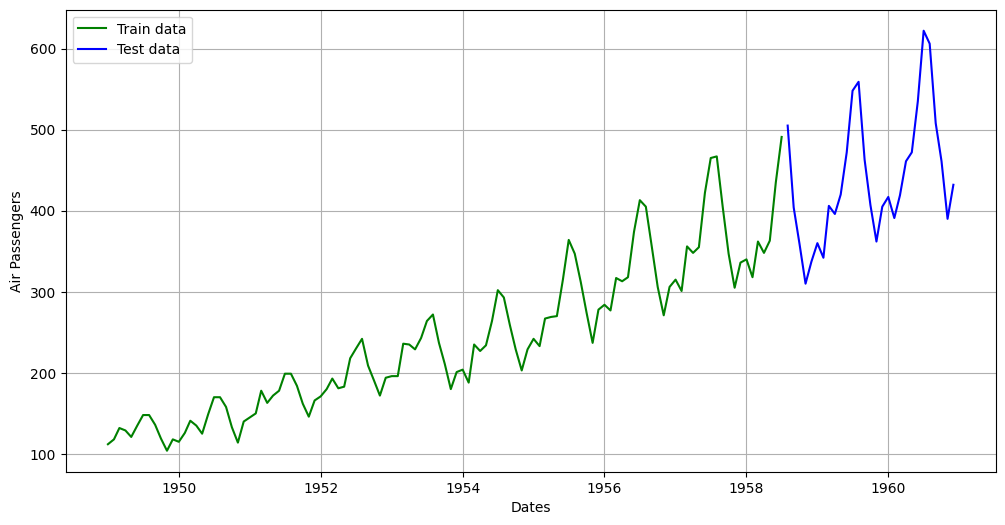

In [9]:
# Spotting training and test set
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel(target_name_for_plot)
plt.plot(df['date'][:int(num_samples * train_ratio)], df[target][:int(num_samples * train_ratio)], 'green', label='Train data')
plt.plot(df['date'][int(num_samples * train_ratio):], df[target][int(num_samples * train_ratio):], 'blue', label='Test data')
plt.legend()
plt.show()

In [10]:
y_train.head()

,passengers
0,112
1,118
2,132
3,129
4,121


## Differencing

In [11]:
# Estimate the optimal number of differences for the target column
d_adf = pm.arima.ndiffs(y_train, test='adf')   # Augmented Dickey-Fuller
print(f"Number of differences required according to ADF: {d_adf}")

Number of differences required according to ADF: 0


In [12]:
# First-order differencing
data_train[target + "_diff"] = y_train.diff()
y_train_diff = y_train.diff().dropna()

In [13]:
data_train

,date,passengers,passengers_diff
0,1949-01-01,112,NaN
1,1949-02-01,118,6.0
2,1949-03-01,132,14.0
3,1949-04-01,129,-3.0
4,1949-05-01,121,-8.0
...,...,...,...
110,1958-03-01,362,44.0
111,1958-04-01,348,-14.0
112,1958-05-01,363,15.0
113,1958-06-01,435,72.0


In [14]:
y_train_diff

,passengers
1,6.0
2,14.0
3,-3.0
4,-8.0
5,14.0
...,...
110,44.0
111,-14.0
112,15.0
113,72.0


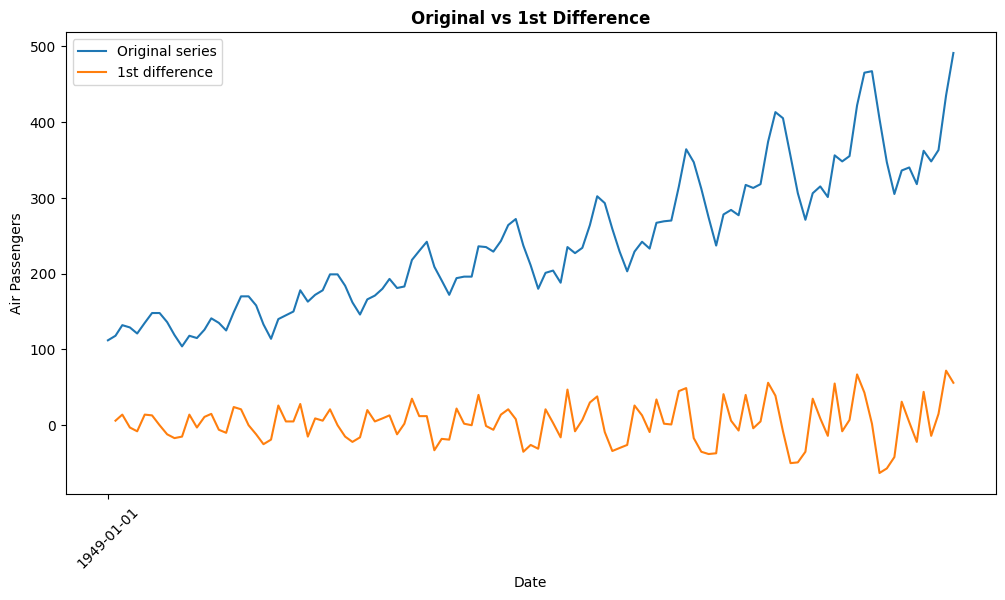

In [15]:
# Plot the original and differenced series
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(data_train["date"], data_train[target], label="Original series")
ax.plot(data_train["date"], data_train[target + "_diff"], label="1st difference")
ax.set_xticks(data_train["date"][::300])
ax.set_xlabel("Date")
ax.set_ylabel(target_name_for_plot)
ax.set_title("Original vs 1st Difference", fontsize=12, fontweight="bold")
plt.xticks(rotation=45)
ax.legend()
plt.show()

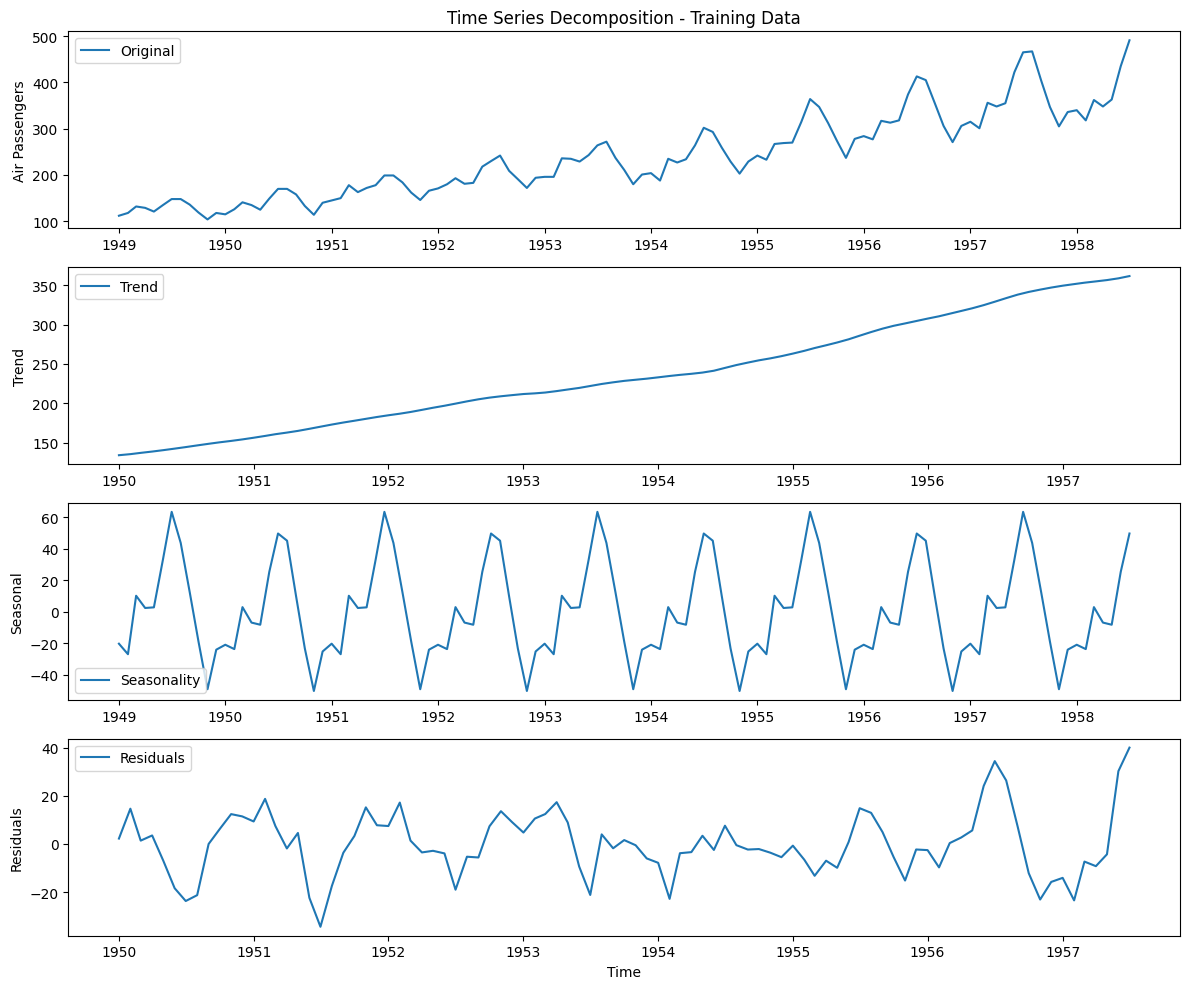

In [16]:
# Seasonal decomposition for training data
decomposition = seasonal_decompose(data_train[target], model='additive', period=24)  # Daily pattern for hourly data

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot decomposition
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(data_train["date"], data_train[target], label='Original')
plt.legend(loc='best')
plt.ylabel(target_name_for_plot)
plt.title('Time Series Decomposition - Training Data')

plt.subplot(4, 1, 2)
plt.plot(data_train["date"], trend, label='Trend')
plt.legend(loc='best')
plt.ylabel('Trend')

plt.subplot(4, 1, 3)
plt.plot(data_train["date"], seasonal, label='Seasonality')
plt.legend(loc='best')
plt.ylabel('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(data_train["date"], residual, label='Residuals')
plt.legend(loc='best')
plt.ylabel('Residuals')
plt.xlabel('Time')

plt.tight_layout()
plt.show()

In [17]:
# StandardScaler
# scaler = StandardScaler()
# y_train[['Cases_diff2']] = scaler.fit_transform(y_train[['Cases_diff2']].dropna())